In [1]:
from datasets import load_dataset

dataset = load_dataset("monash_tsf", "tourism_monthly")


In [18]:
dataset

DatasetDict({
    train: Dataset({
        features: ['start', 'target', 'feat_static_cat', 'feat_dynamic_real', 'item_id'],
        num_rows: 366
    })
    test: Dataset({
        features: ['start', 'target', 'feat_static_cat', 'feat_dynamic_real', 'item_id'],
        num_rows: 366
    })
    validation: Dataset({
        features: ['start', 'target', 'feat_static_cat', 'feat_dynamic_real', 'item_id'],
        num_rows: 366
    })
})

In [22]:
train_dataset = dataset["train"]
val_dataset = dataset["validation"]
test_dataset = dataset["test"]

In [23]:
train_dataset[1]

{'start': datetime.datetime(1979, 1, 1, 0, 0),
 'target': [65072.37109375,
  48612.19921875,
  58452.58984375,
  57033.96875,
  71498.953125,
  79187.109375,
  101896.1015625,
  115971.796875,
  94962.1484375,
  80648.328125,
  64196.078125,
  50364.859375,
  57624.05859375,
  47163.87109375,
  48874.0703125,
  62737.609375,
  69621.1328125,
  71454.21875,
  107916.796875,
  120461.5,
  99441.1796875,
  84936.5390625,
  62809.51953125,
  54028.48046875,
  58605.91015625,
  50516.33984375,
  55711.5390625,
  55798.41015625,
  65033.1796875,
  89421.140625,
  119027.8984375,
  133411.296875,
  112890.703125,
  96718.140625,
  76462.796875,
  57951.6796875,
  62094.69140625,
  55118.23046875,
  66128.3515625,
  71334.2578125,
  75644.71875,
  98380.4296875,
  127255.0,
  146442.703125,
  121934.796875,
  88537.546875,
  71126.1484375,
  80209.5078125,
  72614.40625,
  64114.46875,
  70382.5,
  77124.5390625,
  85675.6796875,
  110282.1015625,
  135361.296875,
  165238.90625,
  139575.0,
 

In [27]:
len(train_dataset[1]["target"]), len(val_dataset[1]["target"]), len(test_dataset[1]["target"])

(139, 163, 187)

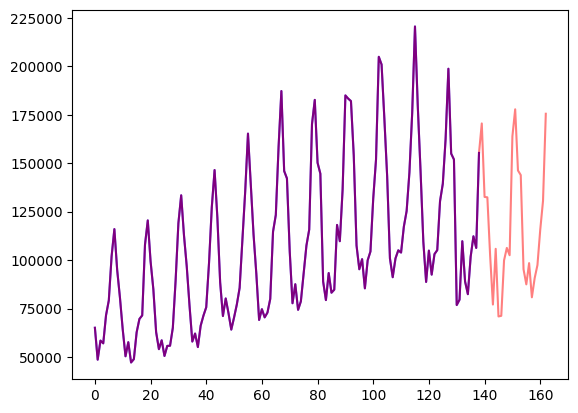

In [25]:
import matplotlib.pyplot as plt

figure, axes = plt.subplots()
axes.plot(train_dataset[1]["target"], color="blue")
axes.plot(val_dataset[1]["target"], color="red", alpha=0.5)

plt.show()


In [29]:
freq = "1M"
prediction_length = 24

from functools import lru_cache, partial

import pandas as pd
import numpy as np

@lru_cache(1000)
def convert_to_pandas_period(date, freq):
    return pd.Period(date, freq)

def transform_start_field(batch, freq):
    batch["start"] = [convert_to_pandas_period(date, freq) for date in batch["start"]]
    return batch

train_dataset.set_transform(partial(transform_start_field, freq=freq))
val_dataset.set_transform(partial(transform_start_field, freq=freq))
test_dataset.set_transform(partial(transform_start_field, freq=freq))


In [11]:
p=convert_to_pandas_period(dataset['train'][1]['start'], freq)

In [17]:
p+2

Period('1979-03', 'M')

In [32]:
import torch
x = torch.randn(16, 1)
x

tensor([[-1.4742],
        [ 1.4487],
        [-0.1520],
        [-0.2411],
        [-0.4028],
        [-1.1271],
        [ 0.8968],
        [-0.2938],
        [-0.2304],
        [ 0.9106],
        [-0.8742],
        [-2.0953],
        [ 2.2034],
        [ 1.5325],
        [ 0.0537],
        [-1.7496]])

In [34]:
std = torch.ones_like(x) / torch.sqrt(torch.tensor(9))
epsilon = torch.normal(mean=torch.zeros_like(x), std=std)

In [35]:
std, epsilon

(tensor([[0.3333],
         [0.3333],
         [0.3333],
         [0.3333],
         [0.3333],
         [0.3333],
         [0.3333],
         [0.3333],
         [0.3333],
         [0.3333],
         [0.3333],
         [0.3333],
         [0.3333],
         [0.3333],
         [0.3333],
         [0.3333]]),
 tensor([[-0.0362],
         [ 0.1629],
         [-0.4487],
         [-0.2872],
         [ 0.4175],
         [-0.0428],
         [-0.0586],
         [ 0.5250],
         [-0.1194],
         [ 0.5667],
         [-0.1166],
         [ 0.3427],
         [-0.2000],
         [ 0.4102],
         [ 0.2610],
         [-0.1666]]))

In [36]:
from torch.distributions import StudentT

In [37]:
from transformers import TimeSeriesTransformerConfig, TimeSeriesTransformerForPrediction

prediction_length = 24
lags_sequence = [1,2,3,6,9,12]

config = TimeSeriesTransformerConfig(
    prediction_length=prediction_length,
    # context length:
    context_length=prediction_length * 2,
    # lags coming from helper given the freq:
    lags_sequence=lags_sequence,
    # we'll add 2 time features ("month of year" and "age", see further):
    num_time_features=2,
    # we have a single static categorical feature, namely time series ID:
    num_static_categorical_features=1,
    # it has 366 possible values:
    cardinality=[10],
    # the model will learn an embedding of size 2 for each of the 366 possible values:
    embedding_dimension=[2],
    
    # transformer params:
    encoder_layers=4,
    decoder_layers=4,
    d_model=32,
)

False

===================================BUG REPORT===================================
The following directories listed in your path were found to be non-existent: {WindowsPath('C')}
The following directories listed in your path were found to be non-existent: {WindowsPath('/matplotlib_inline.backend_inline'), WindowsPath('module')}
CUDA_SETUP: WARNING! libcudart.so not found in any environmental path. Searching in backup paths...
The following directories listed in your path were found to be non-existent: {WindowsPath('/usr/local/cuda/lib64')}
DEBUG: Possible options found for libcudart.so: set()
CUDA SETUP: PyTorch settings found: CUDA_VERSION=116, Highest Compute Capability: 6.1.
CUDA SETUP: To manually override the PyTorch CUDA version please see:https://github.com/TimDettmers/bitsandbytes/blob/main/how_to_use_nonpytorch_cuda.md
CUDA SETUP: Required library version not found: libbitsandbytes_cuda116_nocublaslt.so. Maybe you need to compile it from source?
CUDA SETUP: Defaulting to 

C:\Users\ma.kun\AppData\Local\Continuum\anaconda3\envs\gill\lib\site-packages\bitsandbytes\cuda_setup\main.py:166: UserWarning: Welcome to bitsandbytes. For bug reports, please run

python -m bitsandbytes


  warn(msg)
C:\Users\ma.kun\AppData\Local\Continuum\anaconda3\envs\gill\lib\site-packages\bitsandbytes\cuda_setup\main.py:166: UserWarning: C:\Users\ma.kun\AppData\Local\Continuum\anaconda3\envs\gill did not contain ['libcudart.so', 'libcudart.so.11.0', 'libcudart.so.12.0'] as expected! Searching further paths...
  warn(msg)
C:\Users\ma.kun\AppData\Local\Continuum\anaconda3\envs\gill\lib\site-packages\bitsandbytes\cuda_setup\main.py:166: UserWarning: WARNING: Compute capability < 7.5 detected! Only slow 8-bit matmul is supported for your GPU!                     If you run into issues with 8-bit matmul, you can try 4-bit quantization: https://huggingface.co/blog/4bit-transformers-bitsandbytes
  warn(msg)


RuntimeError: Failed to import transformers.models.time_series_transformer.modeling_time_series_transformer because of the following error (look up to see its traceback):
Failed to import transformers.generation.utils because of the following error (look up to see its traceback):

        CUDA Setup failed despite GPU being available. Please run the following command to get more information:

        python -m bitsandbytes

        Inspect the output of the command and see if you can locate CUDA libraries. You might need to add them
        to your LD_LIBRARY_PATH. If you suspect a bug, please take the information from python -m bitsandbytes
        and open an issue at: https://github.com/TimDettmers/bitsandbytes/issues